# Projeto de Classificação de Ataques de Rede: Implementação de Machine Learning

**Contexto:** Este notebook detalha o processo de Machine Learning para a classificação de tráfego de rede (Normal vs. Anômalo), utilizando dados simulados de tentativas de SQL Injection (SQLi) no ambiente educacional COIL (ISPGAYA/FATECIPI).

**Objetivo:** Desenvolver, otimizar e avaliar um modelo de Random Forest para detectar com alta precisão pacotes que demonstrem características de ataque.

---

In [ ]:
# CÉLULA 1: CONFIGURAÇÃO E IMPORTS ESSENCIAIS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

# ML Modelos e Métricas
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from matplotlib.colors import LogNorm
from sklearn.preprocessing import StandardScaler

# Balanceamento de Classes
from imblearn.over_sampling import SMOTE
from collections import Counter

In [27]:
# CÉLULA 2: FUNÇÕES DE FEATURE ENGINEERING

def extract_ports(info_str):
    if not isinstance(info_str, str): return None, None
    match = re.search(r'(\d{1,5})\s*>?\s*(\d{1,5})', info_str)
    if match: return int(match.group(1)), int(match.group(2))
    match = re.search(r'\s*->\s*(\d{1,5})', info_str)
    if match: return 0, int(match.group(1))
    match_src_dst = re.search(r'\[SRC=(\d{1,5})\s*DST=(\d{1,5})\]', info_str, re.IGNORECASE)
    if match_src_dst: return int(match_src_dst.group(1)), int(match_src_dst.group(2))
    return None, None

def processar_captura_rede(df_raw):
    df = df_raw.copy()

    # Extração de Portas (Contínuas)
    ports_df = df['Info'].apply(lambda x: pd.Series(extract_ports(x), index=['Source_Port', 'Destination_Port']))
    df = pd.concat([df, ports_df], axis=1)
    df['Source_Port'].fillna(0, inplace=True)
    df['Destination_Port'].fillna(0, inplace=True)

    # Extração de Conteúdo (SQLi-Específica - Binárias)
    df['Has_Quote'] = df['Info'].str.contains("'", regex=False, na=False).astype(int)
    df['Has_Comment'] = df['Info'].str.contains("--|#", regex=True, na=False).astype(int)
    df['Has_Union'] = df['Info'].str.contains("UNION SELECT", regex=True, na=False).astype(int)
    df['Has_Or_Logic'] = df['Info'].str.contains(" OR 1=1", regex=False, na=False).astype(int)
    df['Has_Double_Quote'] = df['Info'].str.contains('"', regex=False, na=False).astype(int)

    # One-Hot Encoding Simplificado (Protocolo - Binárias)
    protocol_list = ['TCP', 'UDP', 'DNS', 'HTTP']
    df['Protocol_Base'] = df['Protocol'].apply(lambda x: x if x in protocol_list else 'Outro')
    protocol_dummies = pd.get_dummies(df['Protocol_Base'], prefix='Protocol', dtype=int)
    df = pd.concat([df, protocol_dummies], axis=1)

    # Garantir que todas as 3 colunas Protocolo OHE existem (mesmo que com 0)
    for col in ['Protocol_TCP', 'Protocol_UDP', 'Protocol_Outro']:
        if col not in df.columns:
            df[col] = 0

    # Selecionar as 11 features finais
    final_cols = ['Length', 'Source_Port', 'Destination_Port', 'Has_Quote', 'Has_Comment',
                  'Has_Union', 'Has_Or_Logic', 'Has_Double_Quote', 'Protocol_TCP',
                  'Protocol_UDP', 'Protocol_Outro']

    return df[final_cols]

## 2. Engenharia de Features (Transformação de Dados)

A função `processar_captura_rede` é o núcleo da etapa de pré-processamento, convertendo os dados brutos de pacotes (`Length`, `Protocol`, `Info`) em um formato que o algoritmo de Machine Learning pode processar.

O resultado são 11 features finais: 3 contínuas e 8 binárias/discretas.

### Features Criadas:

* **Features Contínuas:** `Length` (Tamanho do Pacote), `Source_Port`, `Destination_Port`.
* **Heurísticas (Binárias/Discretas):** `Has_Quote`, `Has_Comment`, `Has_Union`, `Has_Or_Logic`, `Has_Double_Quote` (indicadores de *payload* típicos de SQLi).
* **Protocolo (One-Hot Encoded):** `Protocol_TCP`, `Protocol_UDP`, `Protocol_Outro` (capturando características do protocolo de transporte).

In [ ]:
!pip install scapy

In [35]:
from scapy.all import rdpcap, IP, TCP, UDP
def extract_features_from_pcap(pcap_file):
    """Extrai Length, Protocol e Info de um arquivo pcapng/pcap usando Scapy."""
    print(f"Lendo PCAP: {pcap_file} com Scapy...")

    try:
        packets = rdpcap(pcap_file)
    except FileNotFoundError:
        print(f"ERRO: Arquivo PCAP '{pcap_file}' não encontrado. Verifique o caminho.")
        return pd.DataFrame()

    data_list = []

    for pkt in packets:
        # 1. LENGTH (Comprimento do pacote)
        length = len(pkt)

        # 2. PROTOCOL e INFO (A Camada de Aplicação/Transporte)
        protocol = 'UNKNOWN'

        if IP in pkt:
            protocol = pkt[IP].proto
            if protocol == 6: # TCP
                protocol = 'TCP'
            elif protocol == 17: # UDP
                protocol = 'UDP'

            # Tenta encontrar a camada de aplicação mais alta para a info/summary
            info = pkt.summary()

        elif pkt.haslayer('ARP'):
            protocol = 'ARP'
            info = pkt.summary()

        else:
            info = pkt.summary()

        # Corrigir nomes de protocolo para o OHE (One-Hot Encoding)
        # O nome da coluna Info não é exatamente o mesmo que o Wireshark, mas é o suficiente
        # para extrair as 5 features de conteúdo SQLi (Has_Quote, Has_Union, etc.)

        # OHE do modelo espera: TCP, UDP, DNS, HTTP ou Outro
        if 'DNS' in info: protocol = 'DNS'
        if 'HTTP' in info: protocol = 'HTTP'

        data_list.append({
            'Protocol': protocol,
            'Length': length,
            'Info': info # Scapy summary é o melhor Info-equivalente
        })

    print(f"Leitura de {len(data_list)} pacotes concluída.")
    return pd.DataFrame(data_list)

# 1. Tráfego Normal (Label 0): Carregar o arquivo de 50k registros
print("Processando Tráfego NORMAL")
df_raw_normal = pd.read_excel("50k.xlsx")
df_normal = processar_captura_rede(df_raw_normal)
df_normal['Label'] = 0

# 2. Tráfego Anômalo (Label 1): Usando o PCAP com prova de ataque
print("\nProcessando Tráfego ANÔMALO (extracted_SQL_Injection.pcapng)")
df_raw_anomalo = extract_features_from_pcap("extracted_SQL_Injection.pcapng")

# Usar a função de processamento existente
df_anomalo = processar_captura_rede(df_raw_anomalo)
df_anomalo['Label'] = 1


# 3. Combinar e Separar
df_combinado = pd.concat([df_normal, df_anomalo], ignore_index=True)

# Separar Features (X) e Target (y)
X = df_combinado.drop('Label', axis=1)
y = df_combinado['Label']

print(f"\n--- NOVO CONJUNTO COMBINADO ---")
print(f"Shape: {df_combinado.shape}")
print(f"Contagem de Labels: {y.value_counts()}")

Processando Tráfego NORMAL


/tmp/ipython-input-427343132.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Source_Port'].fillna(0, inplace=True)
/tmp/ipython-input-427343132.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df


Processando Tráfego ANÔMALO (extracted_SQL_Injection.pcapng)
Lendo PCAP: extracted_SQL_Injection.pcapng com Scapy...
Leitura de 59252 pacotes concluída.

--- NOVO CONJUNTO COMBINADO ---
Shape: (111374, 12)
Contagem de Labels: Label
1    59252
0    52122
Name: count, dtype: int64


/tmp/ipython-input-427343132.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Source_Port'].fillna(0, inplace=True)
/tmp/ipython-input-427343132.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [22]:
# COMBINAÇÃO E DISTRIBUIÇÃO DOS DADOS

print("Combinando os dois datasets")
# Concatena, alinha as colunas (importante para o One-Hot Encoding) e preenche NaNs com 0
df_combinado = pd.concat([df_normal, df_anomalo], sort=False).fillna(0)

print("Datasets combinados e colunas alinhadas.")
print(f"Shape final do dataset de treino: {df_combinado.shape}")

print("\nDistribuição dos dados (Labels - Desbalanceado):")
print(df_combinado['Label'].value_counts())

Combinando os dois datasets
Datasets combinados e colunas alinhadas.
Shape final do dataset de treino: (63615, 12)

Distribuição dos dados (Labels - Desbalanceado):
Label
1    59252
0     4363
Name: count, dtype: int64


In [36]:
# CÉLULA 4: TRAIN/TEST SPLIT E FEATURE SCALING

# 1. Identificar as features contínuas
continuous_features = ['Length', 'Source_Port', 'Destination_Port']

# 2. Split (Separação do Conjunto)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# 3. FEATURE SCALING (Padronização)
scaler = StandardScaler()

# Cria cópias para evitar SettingWithCopyWarning
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Aplica Scaling APENAS nas features contínuas
X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])

X_train = X_train_scaled
X_test = X_test_scaled

print("Feature Scaling aplicado nas features contínuas (Length, Source_Port, Destination_Port).")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

Feature Scaling aplicado nas features contínuas (Length, Source_Port, Destination_Port).
X_train shape: (77961, 11), y_train shape: (77961,)


In [37]:
# CÉLULA 5: APLICAR SMOTE NO CONJUNTO DE TREINO ESCALADO

smote = SMOTE(random_state=42)


X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Dataset de treino original: {Counter(y_train)}")
print(f"Dataset de treino após SMOTE: {Counter(y_train_smote)}")

Dataset de treino original: Counter({1: 41476, 0: 36485})
Dataset de treino após SMOTE: Counter({1: 41476, 0: 41476})


## 5. Estratégia de Balanceamento de Classes (SMOTE)

A detecção de ataques é um problema inerentemente desbalanceado, pois o volume de tráfego Normal (Label 0) é muito maior que o tráfego Anômalo (Label 1). A Célula 3 demonstrou este desbalanceamento.

* **Técnica:** Foi utilizado o **SMOTE (Synthetic Minority Over-sampling Technique)** no conjunto de treino (`X_train`) para gerar amostras sintéticas da classe minoritária (Ataques/Anômalos).
* **Resultado:** O balanceamento garante que o modelo não apenas aprenda a prever a classe majoritária, mas sim a detectar os padrões de ataque de forma justa.

In [38]:
# CÉLULA 6: RANDOMIZED SEARCH E OTIMIZAÇÃO

# Definir o modelo e os hiperparâmetros
rfc = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Usar F1-Score como métrica de otimização
scorer = make_scorer(f1_score, pos_label=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scorer,
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_smote, y_train_smote)

print(f"\nMelhores parâmetros: {random_search.best_params_}")
print(f"Melhor F1-score na Validação Cruzada: {random_search.best_score_:.4f}")
best_rfc_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Melhores parâmetros: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': True}
Melhor F1-score na Validação Cruzada: 0.9747


## 6. Otimização do Modelo e Escolha de Métrica

Para garantir o melhor desempenho, utilizamos a técnica de otimização **RandomizedSearchCV** sobre 50 combinações de hiperparâmetros do Random Forest.

* **Métrica de Otimização:** Otimizamos pelo **F1-Score (0.9747)**. O F1-Score é a média harmônica de Precision e Recall e é a métrica mais robusta para conjuntos de dados desbalanceados (como o nosso), pois penaliza o modelo se ele falhar em detectar a classe minoritária (ataques).
* **Validação Cruzada:** Foi usada a **StratifiedKFold** (5 *splits*) para garantir que a proporção das classes (Normal/Anômalo) fosse mantida em cada rodada de validação.


Relatório de Classificação (Random Forest Otimizado)
                           precision    recall  f1-score   support

 Tráfego Normal (Label 0)       0.98      0.97      0.97     15637
Tráfego Anômalo (Label 1)       0.97      0.98      0.98     17776

                 accuracy                           0.97     33413
                macro avg       0.97      0.97      0.97     33413
             weighted avg       0.97      0.97      0.97     33413



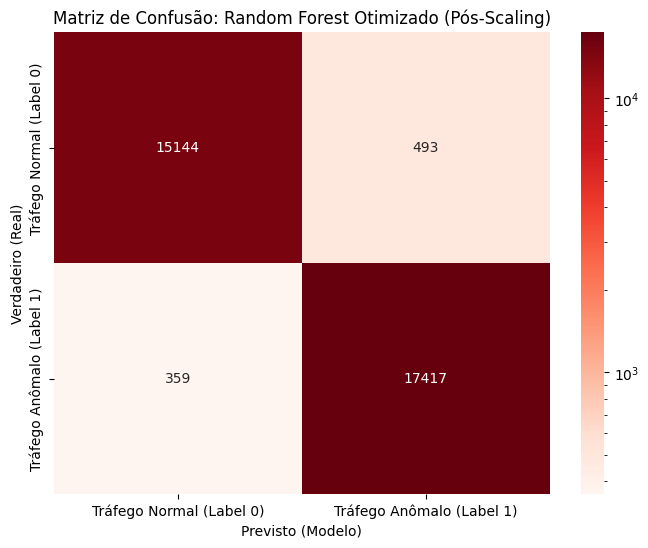


Modelo Random Forest final salvo como 'best_random_forest_final.joblib'


In [ ]:
# CÉLULA 7: AVALIAÇÃO E SALVAMENTO DO MODELO VENCEDOR

# 1. Predição no conjunto de teste (X_test já está escalado)
y_pred_optimized = best_rfc_model.predict(X_test)
target_names = ['Tráfego Normal (Label 0)', 'Tráfego Anômalo (Label 1)']

print("\nRelatório de Classificação (Random Forest Otimizado)")
print(classification_report(y_test, y_pred_optimized, target_names=target_names))

# 2. Calcular e plotar a Matriz de Confusão
cm_optimized = confusion_matrix(y_test, y_pred_optimized)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_optimized,
    annot=True,
    fmt='d',
    cmap='Reds',
    norm=LogNorm(),
    xticklabels=target_names,
    yticklabels=target_names
)
plt.title('Matriz de Confusão: Random Forest Otimizado (Pós-Scaling)')
plt.ylabel('Verdadeiro (Real)')
plt.xlabel('Previsto (Modelo)')
plt.savefig('matriz_final_rf.png')
plt.show()

# 3. Salvar o modelo final (JOB LIB)
joblib.dump(best_rfc_model, 'best_random_forest_final.joblib')
print("\nModelo Random Forest final salvo como 'best_random_forest_final.joblib'")

## 7. Avaliação Final e Serialização do Modelo

A avaliação final no conjunto de teste (visto no Relatório de Classificação e Matriz de Confusão) confirma o sucesso do processo de otimização e balanceamento.

* **Conclusão:** O modelo Random Forest otimizado alcançou uma **Acurácia de 0.97**, com F1-Scores altos e balanceados (0.97 e 0.98), demonstrando alta capacidade de generalização e baixa taxa de falsos positivos/negativos.
* **Serialização:** O modelo vencedor (`best_random_forest_final.joblib`) foi salvo para ser implementado em produção ou para futuras inferências.